In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [0]:
import importlib
import util
importlib.reload(util)
from util import *

# The Training Loop

In [0]:
loss = torch.nn.MSELoss()

In [0]:
def train_it(dataset, model,
             OPTIM=torch.optim.Adam, learning_rate = 1e-1, 
             batch_size=20, Npast=1, Nfuture=1):
    optimizer = OPTIM(model.parameters(), lr=learning_rate)
    Nepoch = 1000

    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Nbatch = batch_size #Ntotal//10
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset, Nfuture)
        y_pred = model(xx)+xx
        L = loss(y_pred,yy[0,:,:])
        h = y_pred
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss(yyt,yt_pred)
            losses[e//Nsave,0] = L.item()
            losses[e//Nsave,1] = test_err.item()
    return losses

In [0]:
dataname = "heat"
data = np.load(root+f"data/{dataname}.npz")
dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
Ntraj,Nt,Nx = dataset.shape

# Test the learning rate:
Let's do a hyperparameter search on the learning rate on the simplest model:

In [8]:
Dt,Dx = 0.25/100 , 1.0/41
alpha = 0.1*Dt/(Dx**2)
print(alpha)
mystencil = PureStencil(Nx)
p = list(mystencil.parameters())[0]
p[0,0,0] =  1 * alpha
p[0,0,1] =  -2 * alpha
p[0,0,2] =  1 * alpha

0.42025


In [9]:
list(mystencil.parameters())

[Parameter containing:
 tensor([[[ 0.4202, -0.8405,  0.4202]]], grad_fn=<CopySlices>)]

In [0]:
dataset.shape

torch.Size([10, 100, 41])

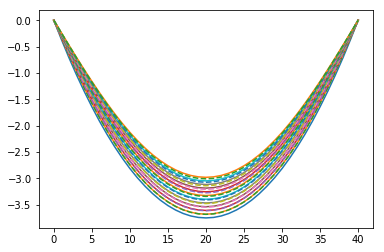

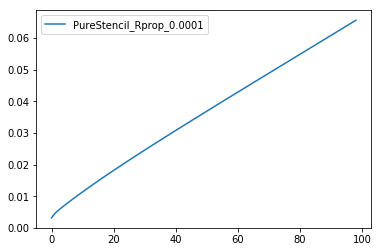

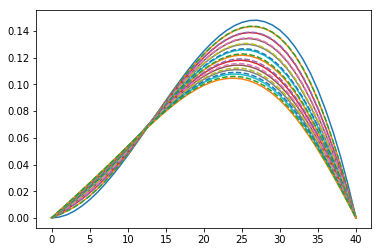

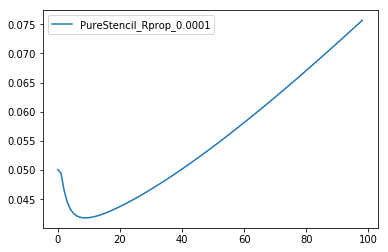

In [0]:
data = np.load(root+f"data/{dataname}.npz")
dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    err[N] = do_a_path(mystencil.to(device),dataset,i,-1)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()

In [0]:
stash_hyper_search = {}

In [185]:
list(model.parameters())

[Parameter containing:
 tensor([[[ 0.1557, -0.3094,  0.1459]]], device='cuda:0', dtype=torch.float64,
        requires_grad=True)]

In [10]:
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    name = "PureStencil"
    model_cls = models[name]
    optimizers = [torch.optim.Adam, torch.optim.Rprop] # torch.optim.SGD,
    for opt in optimizers:
        for lr in [1.0e-1,1.0e-2]:#,1.0e-3,1.0e-4]:
            print("Training ",name, "using ",opt.__name__," @ lr = ",lr)
            model = model_cls(Nx).to(device)
            results = train_it(dataset,model,OPTIM=opt,learning_rate=lr)
            stash_hyper_search[f"{name}_{opt.__name__}_{lr}"] = {'model':model,'loss':results}

Training  PureStencil using  Adam  @ lr =  0.1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1, 41])) that is different to the input size (torch.Size([20, 1, 41])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


4849 0.12325923144817352


KeyboardInterrupt: ignored

In [1]:
for N,S in stash_hyper_search.items():
    plt.semilogy(S['loss'][:,1],label=f"test {N}")
    plt.legend()
plt.show()
for N,S in stash_hyper_search.items():
    plt.semilogy(S['loss'][:,0],label=f"train {N}")
    plt.legend()
plt.show()

NameError: ignored

In [0]:
for k,v in stash_hyper_search.items():
    print(k,":",list(v['model'].parameters())[0].cpu().detach().numpy())

PureStencil_Adam_0.001 : [[[ 0.16958407 -0.34188315  0.16588183]]]
PureStencil_Adam_0.0001 : [[[-0.06283122  0.11868434 -0.07050063]]]
PureStencil_Rprop_0.001 : [[[ 0.18853071 -0.38499734  0.18977275]]]
PureStencil_Rprop_0.0001 : [[[ 0.10422343 -0.22094287  0.10734271]]]
PureStencil_Adam_0.1 : [[[ 0.39218616 -0.8031547   0.39224488]]]
PureStencil_Adam_0.01 : [[[ 0.39908972 -0.79820395  0.39913264]]]
PureStencil_Rprop_0.1 : [[[-0.01926213  0.02744331 -0.02142303]]]
PureStencil_Rprop_0.01 : [[[ 0.15567192 -0.30935293  0.14585517]]]


In [0]:
print([alpha,-2*alpha,alpha])

[0.42025, -0.8405, 0.42025]


PureStencil_Adam_0.001


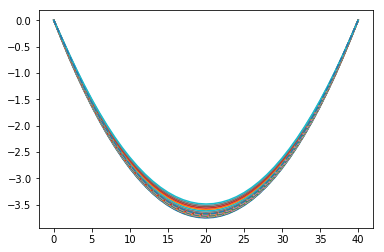

PureStencil_Adam_0.0001


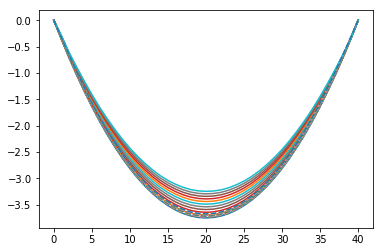

PureStencil_Rprop_0.001


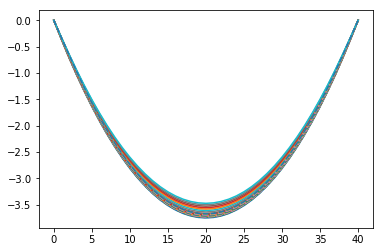

PureStencil_Rprop_0.0001


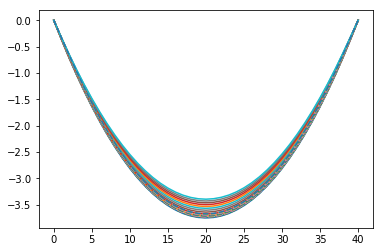

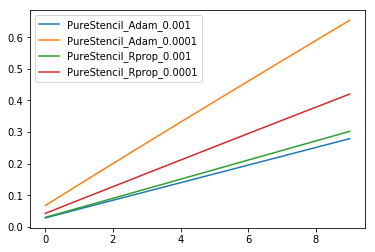

PureStencil_Adam_0.001


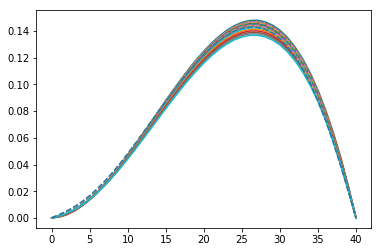

PureStencil_Adam_0.0001


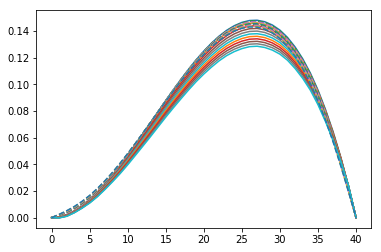

PureStencil_Rprop_0.001


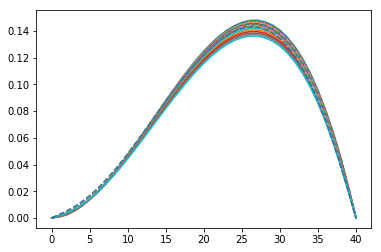

PureStencil_Rprop_0.0001


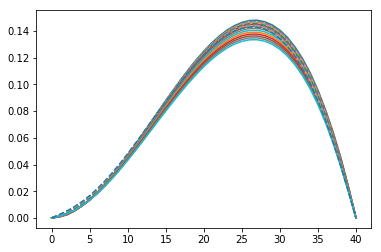

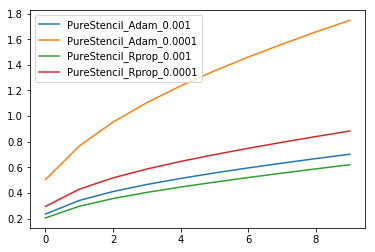

In [0]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash_hyper_search.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,0)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()

# Test 64 bit precision

In [181]:
data['U'].dtype

dtype('float64')

In [0]:
stash_hyper_search64 = {}

In [188]:
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float64,device=device)
    Ntraj,Nt,Nx = dataset.shape
    name = "PureStencil"
    model_cls = models[name]
    optimizers = [torch.optim.Adam, torch.optim.Rprop] # torch.optim.SGD,
    for opt in optimizers:
        for lr in [1.0e-1,1.0e-2,1.0e-3,1.0e-4]:
            print("Training ",name, "using ",opt.__name__," @ lr = ",lr)
            model = model_cls(Nx).double().to(device)
            results = train_it(dataset,model,OPTIM=opt,learning_rate=lr)
            stash_hyper_search64[f"{name}_{opt.__name__}_{lr}"] = {'model':model,'loss':results}

Training  PureStencil using  Adam  @ lr =  0.1
999 8.455552536443602e-06
1999 1.1293388426979605e-06
2999 3.6614365585988677e-07
3999 1.2959880278114971e-09
4999 5.563647594519531e-07
5999 8.513932690714481e-06
6999 1.4679144788046478e-08
7999 1.3263953456821448e-09
8999 4.524229949531517e-10
9999 1.013734222441691e-09
Training  PureStencil using  Adam  @ lr =  0.01
999 0.00012026548482853627
1999 8.125768468653301e-05
2999 7.000492341516569e-05
3999 3.23572222364764e-05
4999 1.321484181408488e-05
5999 5.190399873177848e-06
6999 1.1454498759302506e-06
7999 1.4508493903126396e-07
8999 2.0309586839117284e-08
9999 7.660370023971414e-10
Training  PureStencil using  Adam  @ lr =  0.001
999 4.7843984293873826e-05
1999 4.681116499028659e-05
2999 4.841318667512675e-05
3999 3.8494159740447914e-05
4999 3.608844590312667e-05
5999 2.8371414869658782e-05
6999 3.6028153690773996e-05
7999 2.023865181269408e-05
8999 2.14108535816681e-05
9999 2.0193920118891114e-05
Training  PureStencil using  Adam  @ 

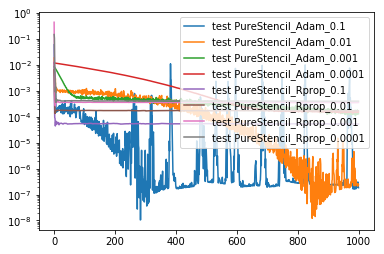

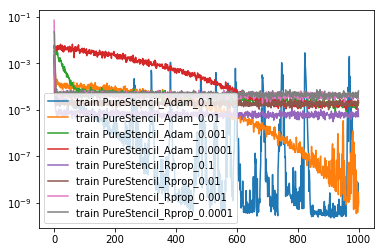

In [189]:
for N,S in stash_hyper_search64.items():
    plt.semilogy(S['loss'][:,1],label=f"test {N}")
    plt.legend()
plt.show()
for N,S in stash_hyper_search64.items():
    plt.semilogy(S['loss'][:,0],label=f"train {N}")
    plt.legend()
plt.show()

In [190]:
for k,v in stash_hyper_search64.items():
    print(k,":",list(v['model'].parameters())[0].cpu().detach().numpy())

PureStencil_Adam_0.1 : [[[ 0.39724946 -0.79462411  0.39725939]]]
PureStencil_Adam_0.01 : [[[ 0.39859032 -0.797078    0.39862185]]]
PureStencil_Adam_0.001 : [[[ 0.12826069 -0.26039106  0.12377495]]]
PureStencil_Adam_0.0001 : [[[ 0.11311086 -0.23083516  0.10853573]]]
PureStencil_Rprop_0.1 : [[[ 0.22608118 -0.45818074  0.22667076]]]
PureStencil_Rprop_0.01 : [[[ 0.10142374 -0.20234239  0.09135457]]]
PureStencil_Rprop_0.001 : [[[-0.03958166  0.05426858 -0.02846123]]]
PureStencil_Rprop_0.0001 : [[[-0.04525586  0.10046891 -0.06966514]]]


# Test the model architecture:

Train all of the models on one of the datasets:

In [206]:
stash = {}
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    for name, cls in models.items():
        print("Training ",name)
        model = cls(Nx).to(device)
        results = train_it(dataset,model)
        stash[name] = {'model':model,
                       'loss':results}

Training  PureStencil
4849 5.981412032340927e-10
9699 2.0847361614784177e-09
14549 1.1723391146745143e-08
19399 1.0614781054130162e-08
24249 1.9879840829073459e-10
29099 4.577042356235239e-10
33949 8.100596637916624e-09
38799 0.00018763872503768653
43649 1.9887740343449423e-09
48499 2.7827115900436183e-07
Training  PureLinear
4849 0.00043745830771513283
9699 0.08133737742900848
14549 0.004080898128449917
19399 0.03569212928414345
24249 0.007979020476341248
29099 0.0005187763017602265
33949 0.0003018990100827068
38799 0.006274476647377014
43649 0.0014510079054161906
48499 0.011251320131123066
Training  DeepStencil
4849 7.552735041826963e-05
9699 0.00012139764294261113
14549 3.6634064599638805e-05
19399 8.015822822926566e-05
24249 0.00011250536044826731
29099 9.669832070358098e-05
33949 4.621098196366802e-05
38799 8.759727643337101e-05
43649 3.375191590748727e-05
48499 0.00010261426359647885
Training  FCMLP
4849 3.2121562981046736e-05
9699 5.494060314958915e-05
14549 7.01967001077719e-05

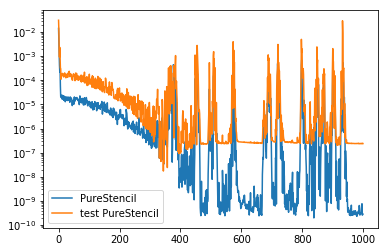

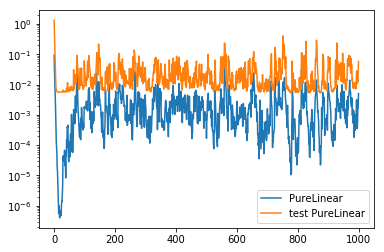

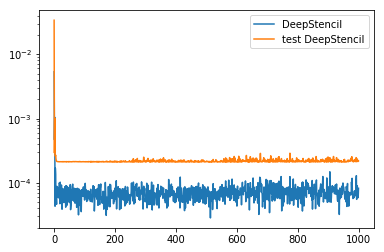

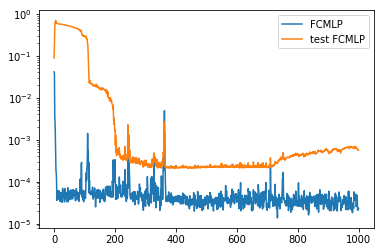

In [200]:
for N,S in stash.items():
    plt.semilogy(S['loss'][:,0],label=N)
    plt.semilogy(S['loss'][:,1],label=f"test {N}")
    plt.legend()
    plt.show()

PureStencil


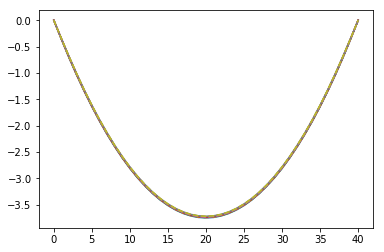

PureLinear


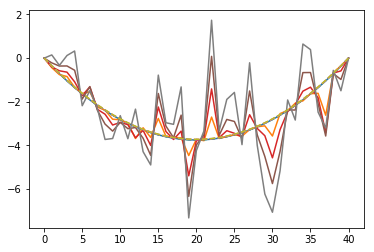

DeepStencil


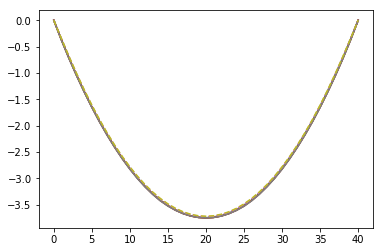

FCMLP


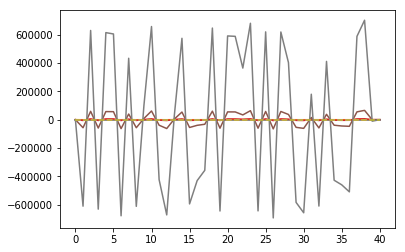

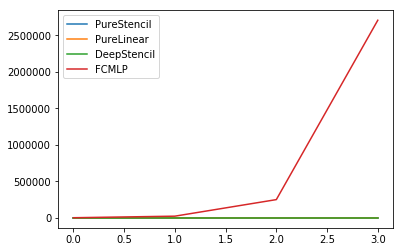

PureStencil


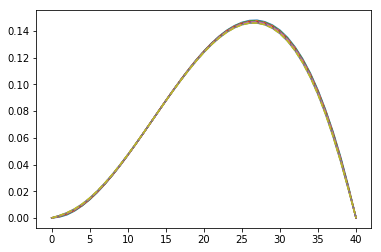

PureLinear


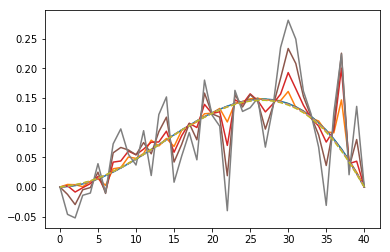

DeepStencil


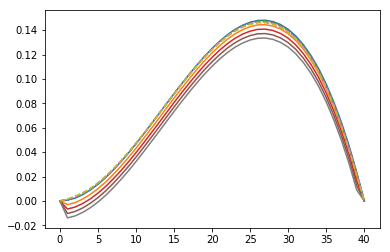

FCMLP


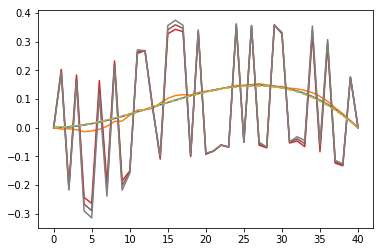

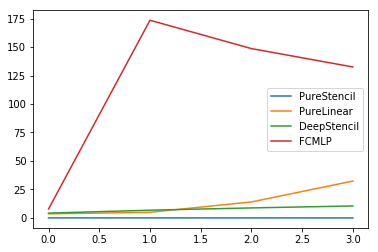

In [207]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,4)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()


In [208]:
list(stash["PureStencil"]['model'].parameters())

[Parameter containing:
 tensor([[[ 0.4006, -0.8013,  0.4007]]], device='cuda:0', requires_grad=True)]

In [0]:
outfile = open(root+'/db','wb')
torch.save(stash,outfile)
outfile.close()

# Burgers' equation

In [12]:
stash = {}
models = {#"PureStencil":PureStencil,
         #"PureLinear":PureLinear,
          "DeepStencil":DeepStencil,
          "LeakyDeepStencil":LeakyDeepStencil,
          "LeakyFCMLP":LeakyFCMLP,
          "FCMLP":FCMLP
         }
for dataname in ["burgers"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    for name, cls in models.items():
        print("Training ",name)
        model = cls(Nx).to(device)
        results = train_it(dataset,model,learning_rate=1.0e-2)
        stash[name] = {'model':model,
                       'loss':results}

Training  DeepStencil
2349 0.0007131200982257724
4699 0.0011290877591818571
7049 0.00045222992775961757
9399 0.002532089361920953
11749 0.003353169420734048
14099 0.0011287997476756573
16449 0.0037744417786598206
18799 0.001381284324452281
21149 0.0005741228233091533
23499 0.0009456108091399074
Training  LeakyDeepStencil
2349 0.002063108840957284
4699 0.0011277594603598118
7049 0.0020472118631005287
9399 0.001826349995099008
11749 0.000509582576341927
14099 0.0003519527381286025
16449 0.0002834192418958992
18799 0.0014533858047798276
21149 0.0008141837315633893
23499 0.0008730292902328074
Training  LeakyFCMLP
2349 0.0038607572205364704
4699 0.003008609637618065
7049 0.004445456434041262
9399 0.005896367598325014
11749 0.002322063548490405
14099 0.0034493894781917334
16449 0.02238195762038231
18799 0.007827133871614933
21149 0.2885197103023529
23499 0.0014476425712928176
Training  FCMLP
2349 0.002802968258038163
4699 0.0027194994036108255
7049 0.005165003705769777
9399 0.004472260829061

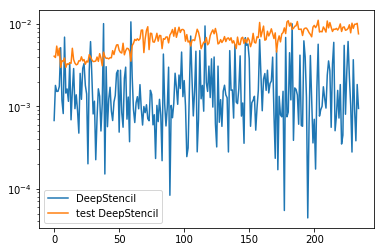

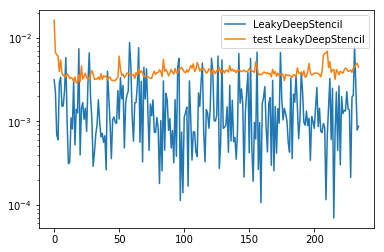

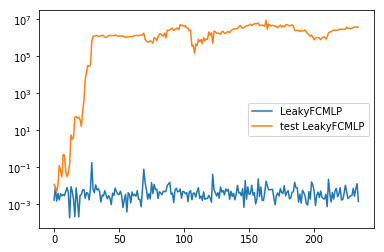

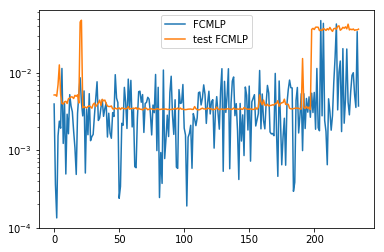

In [13]:
for N,S in stash.items():
    plt.semilogy(S['loss'][:,0],label=N)
    plt.semilogy(S['loss'][:,1],label=f"test {N}")
    plt.legend()
    plt.show()

DeepStencil


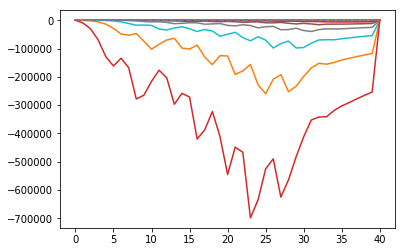

LeakyDeepStencil


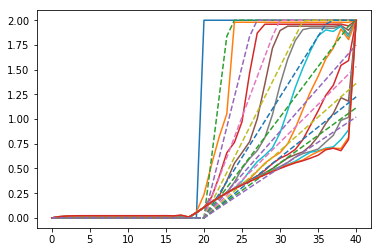

LeakyFCMLP


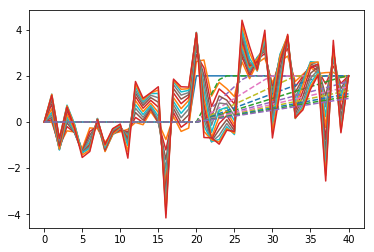

FCMLP


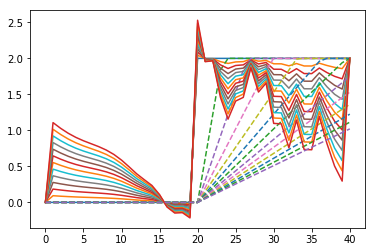

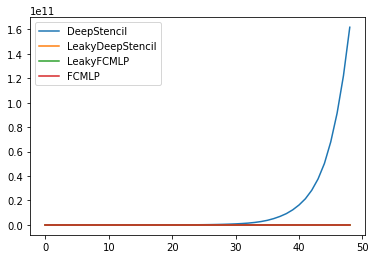

DeepStencil


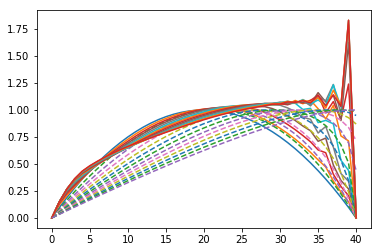

LeakyDeepStencil


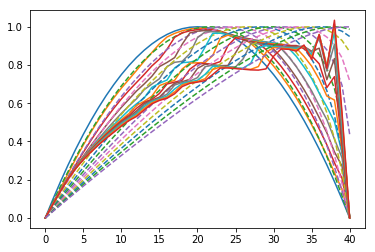

LeakyFCMLP


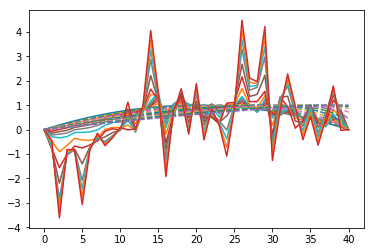

FCMLP


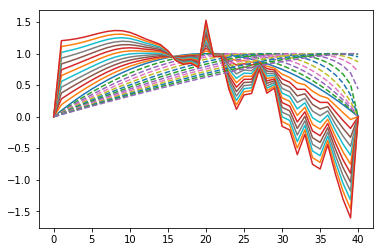

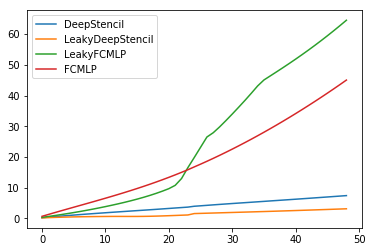

In [14]:
for i in range(Ntraj-Ntraj_val,Ntraj):
    err = {}
    for N,S in stash.items():
        print(N)
        err[N] = do_a_path(S['model'],dataset,i,0)
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.show()